<a href="https://colab.research.google.com/github/DiegoSnach/GLUE-Benchmark/blob/master/5_STSB_with_Simaese_model_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# A few notes from https://github.com/nttuyenx/STS/blob/master/src/util/preprocessing.py

def pearsonr(x, y):
    """
    Pearson correlation between predictions and labels.
    """
    xm = x - K.mean(x)
    ym = y - K.mean(y)
    r_num = K.sum(xm * ym)
    xs = K.sum(K.pow(xm, 2))
    ys = K.sum(K.pow(ym, 2))
    r_den = K.sqrt(xs) * K.sqrt(ys)
    r = r_num / r_den

    return r


In [1]:
from time import time
import datetime
import pandas as pd
import numpy as np
import re
import os
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


GPU is available


In [2]:
# if `batch_size=-1`, will return the full dataset as `tf.tensor`s. ABSOLUTELY FUNDAMENTAL!

train_data, validation_data = tfds.load(name='glue/stsb', split=['train', 'validation'], batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/stsb/1.0.0.incompleteNQD3Z9/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/stsb/1.0.0.incompleteNQD3Z9/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/stsb/1.0.0.incompleteNQD3Z9/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/stsb/1.0.0. Subsequent calls will reuse this data.


In [3]:
# check dataset

train_data.keys()

dict_keys(['idx', 'label', 'sentence1', 'sentence2'])

In [4]:
# Convert to dataFrame

df_train = pd.DataFrame(data=train_data)
df_validation = pd.DataFrame(data=validation_data)

In [5]:
df_validation.label

0       0.4
1       3.4
2       2.6
3       0.8
4       2.2
       ... 
1495    1.6
1496    3.2
1497    5.0
1498    2.8
1499    3.0
Name: label, Length: 1500, dtype: float32

In [6]:
# Creates function to clean data and the first b

def process_data (data):
  punct = "/-?!.,#$%\()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
  def clean_the_text (text, punt):
    for p in punct:
      text = text.replace(p, ' ')
      text = text.replace("b'", ' ', 1)
      text = text.replace('b"', ' ', 1)
    return text
  
  data =  data.astype(str).apply(lambda x: clean_the_text(x, punct))
  return data  
 

In [12]:
def labelsOK(label):

  # Rescales the training-set relatedness labels to lie ∈[0,1]
  
  labelsOK = []
  for lab in label:
    tmp = lab/5
    labelsOK.append(round(tmp,2))
  return np.asarray(labelsOK)


In [24]:
label = labelsOK(df_train.label)
print(label)

[0.96 0.52 0.76 ... 0.64 0.4  0.68]


In [25]:
# Change the datatypes as they come as tensor object

sentence1 = process_data(df_train.sentence1.apply(str))
sentence2 = process_data(df_train.sentence2.apply(str))
label = labelsOK(df_train.label)
print(len(sentence1))
print(len(sentence2))
print(len(label))

5749
5749
5749


In [26]:
label

array([0.96, 0.52, 0.76, ..., 0.64, 0.4 , 0.68])

In [27]:
# Check lenght of sentence

count = sentence1.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count.mean()))
print('Median: %f' % (count.median()))
print('Max: %f' % (count.max()))

Mean: 10.754218
Median: 9.000000
Max: 58.000000


In [28]:
# Count it for sentence 2

count2 = sentence2.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count2.mean()))
print('Median: %f' % (count2.median()))
print('Max: %f' % (count2.max()))

Mean: 10.759958
Median: 9.000000
Max: 48.000000


In [29]:
# Bring Keras tokenizer, builds vocabulary and pads sequences

Tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000, lower=False, oov_token=1)
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

tokenizer = Tokenizer
max_len = 32 # Limit sentences to 25 words

# Creates vocabulary and gives number of tokens in corpus

tokenizer.fit_on_texts(list(sentence1) + list(sentence2))
vocab_size = len(tokenizer.word_index)+1 # Because starts counting at 0
print(vocab_size)

15103


In [30]:
# Converts sentences to sequences of integers
# post pad them to max set to 40 

encoded_sent1 = tokenizer.texts_to_sequences(sentence1)
padded_sent1 = pad_sequences(encoded_sent1, maxlen=max_len, padding='post')

encoded_sent2 = tokenizer.texts_to_sequences(sentence2)
padded_sent2 = pad_sequences(encoded_sent2, maxlen=max_len, padding='post')

# Check
print(sentence1[5])
print(encoded_sent1[5])
print(padded_sent1[5])

 At one of the three sampling sites at Huntington Beach  the bacteria reading came back at 160 on June 16 and at 120 on June 23 '
[237, 94, 9, 3, 157, 5509, 1689, 16, 5510, 3386, 3, 5511, 2151, 558, 186, 16, 4231, 11, 401, 578, 10, 16, 2863, 11, 401, 641, 2]
[ 237   94    9    3  157 5509 1689   16 5510 3386    3 5511 2151  558
  186   16 4231   11  401  578   10   16 2863   11  401  641    2    0
    0    0    0    0]


In [31]:
val_sentence1 = process_data(df_validation.sentence1.apply(str))
val_sentence2 = process_data(df_validation.sentence2.apply(str))
val_label = labelsOK(df_validation.label)
print(len(val_sentence1))
print(len(val_sentence2))
print(len(val_label))

1500
1500
1500


In [32]:
# Converts sentences to sequences of integers for VAL_SET
# post pad them to max set to 40 

val_encoded_sent1 = tokenizer.texts_to_sequences(val_sentence1)
val_padded_sent1 = pad_sequences(val_encoded_sent1, maxlen=max_len, padding='post')

val_encoded_sent2 = tokenizer.texts_to_sequences(val_sentence2)
val_padded_sent2 = pad_sequences(val_encoded_sent2, maxlen=max_len, padding='post')

# Check
print(val_sentence1[5])
print(val_encoded_sent1[5])
print(val_padded_sent1[5])

 Two people in snowsuits laying in the snow making snow angels'
[28, 43, 5, 1, 329, 5, 3, 107, 567, 107, 1]
[ 28  43   5   1 329   5   3 107 567 107   1   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [22]:
# # download pretrained GloVe embeddings

# !wget http://nlp.stanford.edu/data/glove.6B.zip

# !unzip glove.6B.zip

In [33]:
# Mount them from drive for quicker performance

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [34]:
# lists files

!ls "/content/gdrive/My Drive/Glove/glove.6B.300d.txt"

'/content/gdrive/My Drive/Glove/glove.6B.300d.txt'


In [35]:
# Creates dictionary of word embeddings

glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join('/content/gdrive/My Drive/Glove/glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [36]:
# Matches words/tokens from vocabulary to their embeddings

embedding_dimensions = 300

embedding_matrix = np.zeros((vocab_size, embedding_dimensions))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector   

In [37]:
# Builds a dict for the two inputs of the Siamese LSTM

X_train = {'left': padded_sent1, 'right': padded_sent2}
Y_train = label

In [38]:
# Make sure everything is ok
# CHECK WHETHER THIS IS NEEDED OR IT CAN BE DIFFERENT LENGHT

assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(label)

In [39]:
# Builds a dict for the two inputs of the Siamese LSTM at validation as well

X_val = {'left': val_padded_sent1, 'right': val_padded_sent2}
Y_val = val_label

In [40]:
# Make sure everything is ok
# CHECK WHETHER THIS IS NEEDED OR IT CAN BE DIFFERENT LENGHT

assert X_val['left'].shape == X_val['right'].shape
assert len(X_val['left']) == len(val_label)

In [41]:
# Calculates Manhattan Distance as in Jonas Mueller. Taken from:
# https://gist.github.com/GKarmakar/3aa0c643ddb0688a9bfc44b43b84edd8

def manhattan_distance(left,right):
  return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [42]:
# Starts building model Siamese LSTM

from tensorflow.python.keras.layers import Input, Embedding, LSTM, GRU, Conv1D, Conv2D, GlobalMaxPool1D, Dense, Dropout
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Layer

In [100]:
# Defines hidden dimensions of lstm and embedding
# From Jonas Mueller: The LSTM learns a mapping from the space of variable length 
# sequences of 300 dimensional vectors into 50 (100 D for us )

n_hidden = 50

embed = Embedding(vocab_size, embedding_dimensions, weights=[embedding_matrix],input_length=max_len, trainable=True)

In [101]:
# Defines LSTM_model and shows it

lstm_layer = Sequential()
lstm_layer.add(embed)
lstm_layer.add(LSTM(n_hidden))
#lstm_layer.add(Dense(1, activation='sigmoid'))
lstm_layer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 300)           4530900   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
Total params: 4,601,100
Trainable params: 4,601,100
Non-trainable params: 0
_________________________________________________________________


In [102]:
# Defines left and right inputs to the lstm
# Input has automatic shape inference

left_input = Input(shape=(max_len,), dtype='int32')
right_input = Input(shape=(max_len,), dtype='int32')

# Output of the lstm

left = lstm_layer(left_input)
right = lstm_layer(right_input)

In [73]:
from keras.layers.merge import multiply, concatenate

In [103]:
# Calculates Manhattan Distance and instantiates the Model
# when training the model, the weights of the LSTM layer are updated based on both inputs

malstm_distance = manhattan_distance(left=left, right=right)
# sen_representation = tf.keras.layers.concatenate([left,right, malstm_distance])
# similarity = Dense(1, activation='relu')(sen_representation)
# x = Dense(24, activation='sigmoid')(malstm_distance)
# preds = Dense(1, activation='softmax')(x)

model = Model(inputs = [left_input, right_input], outputs = [malstm_distance])

In [104]:
# Compiles with loss MSE and Adadelta as in Jonas Mueller. Prints summary

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50)           4601100     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 50)]         0           sequential[1][0]             

In [105]:
# Early stopping to prevent under/over fitting

from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss',patience=3, verbose=0, mode='auto')

In [106]:
# start training
malstm_trained = model.fit([X_train['left'], X_train['right']], label, 
                           batch_size=16,
                           epochs=10, verbose=True,                            
                           validation_split=0.2,
                           callbacks=[earlystop])

Epoch 1/10
288/288 [==============================] - 18s 63ms/step - loss: 0.1130 - accuracy: 0.0768 - val_loss: 0.1020 - val_accuracy: 0.0800
Epoch 2/10
288/288 [==============================] - 18s 62ms/step - loss: 0.0589 - accuracy: 0.0996 - val_loss: 0.0981 - val_accuracy: 0.0739
Epoch 3/10
288/288 [==============================] - 18s 61ms/step - loss: 0.0340 - accuracy: 0.1065 - val_loss: 0.0948 - val_accuracy: 0.0826
Epoch 4/10
288/288 [==============================] - 18s 62ms/step - loss: 0.0238 - accuracy: 0.1094 - val_loss: 0.0933 - val_accuracy: 0.0783
Epoch 5/10
288/288 [==============================] - 18s 62ms/step - loss: 0.0200 - accuracy: 0.1102 - val_loss: 0.0947 - val_accuracy: 0.0809
Epoch 6/10
288/288 [==============================] - 18s 62ms/step - loss: 0.0159 - accuracy: 0.1107 - val_loss: 0.0968 - val_accuracy: 0.0774
Epoch 7/10
288/288 [==============================] - 18s 62ms/step - loss: 0.0137 - accuracy: 0.1109 - val_loss: 0.0928 - val_accuracy:

In [107]:
evaluation = model.evaluate([X_val['left'], X_val['right']], val_label)
print(evaluation)

47/47 [==============================] - 0s 8ms/step - loss: 0.0929 - accuracy: 0.0813
[0.09292221814393997, 0.08133333176374435]


In [108]:
prediction = model.predict([X_val['left'],X_val['right']])
print(prediction)

[[0.51414275]
 [0.6154924 ]
 [0.59236   ]
 ...
 [0.9044499 ]
 [0.6567167 ]
 [0.6302656 ]]


In [98]:
K.clear_session()


In [ ]:
prediction?

In [ ]:
for pred in prediction:
  result = pred * 5
  print(result)

In [110]:
def result(predict):

  # Rescales the predicted labels to lie ∈[0,5]
  
  results = []
  for pred in predict:
    tmp = pred * 5
    results.append(tmp)
  return np.asarray(results)

In [111]:
Xs = result(predict=prediction)

In [112]:
Xs.shape = (1500,)

In [113]:
Xs

array([2.5707138, 3.077462 , 2.9618   , ..., 4.522249 , 3.2835836,
       3.151328 ], dtype=float32)

In [114]:
gold = df_validation.label.to_numpy()

In [115]:
def golden(gold):

  # Rescales the training-set relatedness labels to lie ∈[0,1]
  
  truevalues = []
  for gol in gold:
    
    truevalues.append(gol)
  return np.asarray(truevalues)

In [116]:
Ys = golden(gold=gold)

In [117]:
Ys

array([0.4, 3.4, 2.6, ..., 5. , 2.8, 3. ], dtype=float32)

In [118]:
from scipy.stats import pearsonr
import scipy.stats

In [119]:
correlacion_pearson = scipy.stats.pearsonr(x=Xs, y=Ys)

In [120]:
correlacion_pearson

(0.40633707205851916, 1.0096251265813124e-60)

In [121]:
correlacion_spearman = scipy.stats.spearmanr(a=Xs, b=Ys)

In [122]:
correlacion_spearman

SpearmanrResult(correlation=0.3961886545491047, pvalue=1.488857529713379e-57)

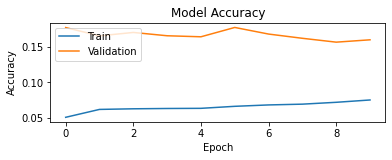

In [97]:
# Plot Accuracy

plt.subplot(211)
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

In [ ]:
# Plot loss

plt.subplot(211)
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')

In [ ]:
def encode_labels(label):

  """
  Encode labels as in Tai et al., 2015
  ...after rescaling the training-set relatedness labels to lie ∈[0,1]
  """
  labels_to_probs = []
  for lab in label:
    tmp = np.zeros(6, dtype=np.float32)
    if (int(lab)+1 > 5):
      tmp[5] = 1
    else:
      tmp[int(lab)+1] = lab - int(lab)
      tmp[int(lab)] = int(lab) - lab + 1
    labels_to_probs.append(tmp)
  return np.asarray(labels_to_probs)
